In [1]:
# Chunk 1: Import necessary libraries and load datasets
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load ACLED and Reddit datasets
acled = pd.read_csv("/content/Cleaned_ACLED_Data_03.12.2025_by YF.csv")
reddit = pd.read_csv("/content/final_updated_sentiment_comments.csv")

# Preview the ACLED dataset
print(acled.head())
print(acled.info())
print(acled.describe())

   event_date  time_precision           disorder_type  \
0  2025-01-24               1          Demonstrations   
1  2025-01-24               1          Demonstrations   
2  2025-01-24               1  Strategic developments   
3  2025-01-24               1      Political violence   
4  2025-01-24               1      Political violence   

                   event_type                sub_event_type  \
0                       Riots         Violent Demonstration   
1                    Protests     Protest With Intervention   
2      Strategic Developments  Looting/Property Destruction   
3  Violence Against Civilians                        Attack   
4  Violence Against Civilians                        Attack   

                              actor1  assoc_actor_1                 inter1  \
0                   Rioters (Israel)        Unknown                Rioters   
1                Protesters (Israel)        Unknown             Protesters   
2                  Settlers (Israel)  Hashom

In [2]:
# chunk 2: Preview the Reddit dataset
print(reddit.head())
print(reddit.info())
print(reddit.describe())

   score                                           comments        subreddit  \
0      1              their voices are absolutely beautiful        Palestine   
1      1  I was naming the historical reasons. Neither E...  IsraelPalestine   
2      1                         ya got brainwashed pardner  IsraelPalestine   
3      1  are Palestinians still living in Jordan and Eg...  IsraelPalestine   
4      1  The excuse that the Palestinians have a valid ...  IsraelPalestine   

          created_time                                         post_title  \
0  2025-01-28 12:34:45                                 My Hometown GAZA !   
1  2025-01-28 12:34:36  Why is it so uniquely bad for Palestinians to ...   
2  2025-01-28 12:34:11                              Psychological Warfare   
3  2025-01-28 12:33:47  Why is it so uniquely bad for Palestinians to ...   
4  2025-01-28 12:33:34  Thoughts on a refined Clinton Proposal? How wo...   

                                     distilbert_text dis

In [3]:
# Chunk 3: Standardize and truncate datetime fields to just dates
acled['date'] = pd.to_datetime(acled['event_date']).dt.date
reddit['date'] = pd.to_datetime(reddit['created_time']).dt.date

# Verify date ranges
print("ACLED date range:", acled['date'].min(), "to", acled['date'].max())
print("Reddit date range:", reddit['date'].min(), "to", reddit['date'].max())

ACLED date range: 2023-10-07 to 2025-01-24
Reddit date range: 2023-09-02 to 2025-01-28


In [4]:
# Chunk 4: Display raw event_type distribution
print("Original event_type distribution:")
print(acled['event_type'].value_counts())

Original event_type distribution:
event_type
Explosions/Remote Violence    18781
Riots                          6173
Strategic Developments         4196
Battles                        3856
Protests                       2390
Violence Against Civilians     1737
Name: count, dtype: int64


In [5]:
# Chunk 5: Clean and normalize event_type labels
acled['event_type'] = acled['event_type'].str.strip().str.lower()
acled['event_type'] = acled['event_type'].replace({
    'explosions/remote violence': 'explosions',
    'strategic developments': 'strategic',
    'violence against civilians': 'violence_civilians',
    'battles': 'battles',
    'protests': 'protests',
    'riots': 'riots'
})

# Confirm cleaned distribution
print("\nCleaned event_type distribution after renaming:")
print(acled['event_type'].value_counts())
print(f"\nTotal rows before rename: {acled.shape[0]}")


Cleaned event_type distribution after renaming:
event_type
explosions            18781
riots                  6173
strategic              4196
battles                3856
protests               2390
violence_civilians     1737
Name: count, dtype: int64

Total rows before rename: 37133


In [6]:
# Chunk 6: Aggregate daily conflict type counts by region
conflict_types = ['battles', 'explosions', 'protests', 'riots', 'strategic', 'violence_civilians']

# Split data by region
acled_israel = acled[acled['country'] == 'Israel']
acled_palestine = acled[acled['country'] == 'Palestine']

# Group by date and event type, convert to wide format
conflict_israel = acled_israel[acled_israel['event_type'].isin(conflict_types)] \
    .groupby(['date', 'event_type']).size().unstack(fill_value=0).reset_index()
conflict_palestine = acled_palestine[acled_palestine['event_type'].isin(conflict_types)] \
    .groupby(['date', 'event_type']).size().unstack(fill_value=0).reset_index()

# Ensure all conflict types are present
for col in conflict_types:
    if col not in conflict_israel.columns:
        conflict_israel[col] = 0
    if col not in conflict_palestine.columns:
        conflict_palestine[col] = 0

# Reorder columns
conflict_israel = conflict_israel[['date'] + conflict_types]
conflict_palestine = conflict_palestine[['date'] + conflict_types]

# Print total events per conflict type
print("Total conflict events (Israel):\n", conflict_israel.drop(columns='date').sum())
print("\nTotal conflict events (Palestine):\n", conflict_palestine.drop(columns='date').sum())

Total conflict events (Israel):
 event_type
battles                340
explosions            4117
protests              1668
riots                  178
strategic             1274
violence_civilians      99
dtype: int64

Total conflict events (Palestine):
 event_type
battles                3516
explosions            14664
protests                722
riots                  5995
strategic              2922
violence_civilians     1638
dtype: int64


In [7]:
# Chunk 7: Filter Reddit sentiment by region-specific keywords and aggregate by day
israel_keywords = ['Israel', 'Israeli', 'IDF', 'Israel Defense Forces', 'Netanyahu', 'Benjamin Netanyahu',
    'Jerusalem', 'Tel Aviv', 'Haifa', 'Ashkelon', 'Ashdod', 'Iron Dome', 'Kibbutz',
    'Zionist', 'Zionism', 'Knesset', 'Israeli government', 'Mossad',
    'Israeli army', 'Israeli military', 'Israeli strike', 'Israeli airstrike',
    'Israel-Gaza', 'Israel-Hamas', 'Israel-Palestine']

palestine_keywords = ['Palestine', 'Palestinian', 'Gaza', 'West Bank', 'Ramallah', 'Nablus', 'Jenin', 'Hebron',
    'Hamas', 'Islamic Jihad', 'Fatah', 'Al-Aqsa', 'Refugee camps', 'Nakba',
    'Occupation', 'Blockade', 'Palestinian Authority', 'Intifada',
    'Gaza Strip', 'Gazan', 'Palestinian resistance', 'Palestinian civilians',
    'Palestinian protest', 'Palestinian children', 'Israel-Palestine', 'Gaza-Israel']

# Combine title and comment fields
reddit['text'] = reddit['post_title'].fillna('') + ' ' + reddit['comments'].fillna('')

# Signed sentiment column
reddit['signed_sentiment'] = reddit.apply(
    lambda row: row['distilbert_score'] if row['distilbert_label'] == 'positive'
    else (-row['distilbert_score'] if row['distilbert_label'] == 'negative' else 0),
    axis=1
)

# Filter by keywords
reddit_israel = reddit[reddit['text'].str.contains('|'.join(israel_keywords), case=False, na=False)]
reddit_palestine = reddit[reddit['text'].str.contains('|'.join(palestine_keywords), case=False, na=False)]

# Aggregate mean sentiment scores daily
sentiment_israel = reddit_israel.groupby('date')['signed_sentiment'].mean().reset_index()
sentiment_palestine = reddit_palestine.groupby('date')['signed_sentiment'].mean().reset_index()

# Rename columns for clarity
sentiment_israel.columns = ['date', 'sentiment_israel']
sentiment_palestine.columns = ['date', 'sentiment_palestine']

# Preview
print("Sample sentiment (Israel):\n", sentiment_israel.head())
print("Sample sentiment (Palestine):\n", sentiment_palestine.head())

Sample sentiment (Israel):
          date  sentiment_israel
0  2023-09-02         -0.516726
1  2023-09-03         -0.689928
2  2023-09-04         -0.182603
3  2023-09-05          0.054396
4  2023-09-06         -0.595962
Sample sentiment (Palestine):
          date  sentiment_palestine
0  2023-09-02            -0.986317
1  2023-09-03            -0.892846
2  2023-09-04            -0.028042
3  2023-09-05             0.512111
4  2023-09-10            -0.473711


In [8]:
# Chunk 8: Merge conflict and sentiment data by date
conflict_israel = pd.merge(conflict_israel, sentiment_israel, on='date', how='left')
conflict_palestine = pd.merge(conflict_palestine, sentiment_palestine, on='date', how='left')

# Check number of matched dates
print("Israel sentiment dates (non-NaN):", conflict_israel['sentiment_israel'].notna().sum())
print("Palestine sentiment dates (non-NaN):", conflict_palestine['sentiment_palestine'].notna().sum())

Israel sentiment dates (non-NaN): 471
Palestine sentiment dates (non-NaN): 475


In [9]:
# Chunk 9: Create lagged sentiment columns (t+1, t+2, t+3)
for lag in [1, 2, 3]:
    conflict_israel[f'sentiment_t{lag}'] = conflict_israel['sentiment_israel'].shift(-lag)
    conflict_palestine[f'sentiment_t{lag}'] = conflict_palestine['sentiment_palestine'].shift(-lag)

# Preview lagged values
print(" Lagged sentiment preview (Israel):\n", conflict_israel[['date', 'sentiment_t1', 'sentiment_t2', 'sentiment_t3']].dropna().head())

 Lagged sentiment preview (Israel):
          date  sentiment_t1  sentiment_t2  sentiment_t3
0  2023-10-07     -0.547160     -0.615225     -0.558581
1  2023-10-08     -0.615225     -0.558581     -0.542846
2  2023-10-09     -0.558581     -0.542846     -0.453518
3  2023-10-10     -0.542846     -0.453518     -0.576191
4  2023-10-11     -0.453518     -0.576191     -0.719057


In [10]:
# Chunk 10: Run OLS regressions for each lag
def run_regression(df, sentiment_col, label):
    df_clean = df.dropna(subset=[sentiment_col])
    X = df_clean[conflict_types]
    y = df_clean[sentiment_col]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(f"\n OLS Regression Results ({label}):")
    print(model.summary())

# Run regressions for all lags
for lag in [1, 2, 3]:
    run_regression(conflict_israel, f'sentiment_t{lag}', f'Israel t+{lag}')
    run_regression(conflict_palestine, f'sentiment_t{lag}', f'Palestine t+{lag}')


 OLS Regression Results (Israel t+1):
                            OLS Regression Results                            
Dep. Variable:           sentiment_t1   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9017
Date:                Fri, 01 Aug 2025   Prob (F-statistic):              0.493
Time:                        11:58:52   Log-Likelihood:                 937.47
No. Observations:                 470   AIC:                            -1861.
Df Residuals:                     463   BIC:                            -1832.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [11]:
# Chunk 11: Extract regression coefficients (excluding intercept)
def get_coefficients(df, sentiment_col):
    df_clean = df.dropna(subset=[sentiment_col])
    X = df_clean[conflict_types]
    y = df_clean[sentiment_col]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model.params.drop("const", errors='ignore')

# Collect coefficients across all lags
coeffs_israel = {f't+{lag}': get_coefficients(conflict_israel, f'sentiment_t{lag}') for lag in [1, 2, 3]}
coeffs_palestine = {f't+{lag}': get_coefficients(conflict_palestine, f'sentiment_t{lag}') for lag in [1, 2, 3]}

# Convert to DataFrame
coeffs_israel_df = pd.DataFrame(coeffs_israel)
coeffs_palestine_df = pd.DataFrame(coeffs_palestine)

# Display coefficient tables
print("OLS Coefficients by Lag - ISRAEL:")
print(coeffs_israel_df.round(6))

print("\nOLS Coefficients by Lag - PALESTINE:")
print(coeffs_palestine_df.round(6))

OLS Coefficients by Lag - ISRAEL:
                         t+1       t+2       t+3
battles            -0.000383  0.000594  0.000282
explosions         -0.000024  0.000225  0.000174
protests           -0.000731 -0.000306 -0.000198
riots               0.002100 -0.002056 -0.001618
strategic          -0.000231 -0.001194 -0.000737
violence_civilians  0.000186 -0.003751 -0.000810

OLS Coefficients by Lag - PALESTINE:
                         t+1       t+2       t+3
battles            -0.000537  0.000166  0.000362
explosions         -0.000229 -0.000382 -0.000298
protests            0.000304  0.001428  0.000164
riots               0.000278  0.000027 -0.000554
strategic           0.000160  0.000358  0.001124
violence_civilians -0.000675 -0.000935  0.000521


In [12]:
# Chunk 12: Identify most impactful conflict type per lag
def top_influencer(coeff_dict, region):
    print(f"\nMost impactful conflict types for {region}:")
    for lag, series in coeff_dict.items():
        top_type = series.abs().idxmax()
        sign = np.sign(series[top_type])
        direction = "positive" if sign > 0 else "negative"
        print(f"  {lag}: {top_type} ({series[top_type]:.6f}) {direction}")

# Display top influencers
top_influencer(coeffs_israel, "Israel")
top_influencer(coeffs_palestine, "Palestine")


Most impactful conflict types for Israel:
  t+1: riots (0.002100) positive
  t+2: violence_civilians (-0.003751) negative
  t+3: riots (-0.001618) negative

Most impactful conflict types for Palestine:
  t+1: violence_civilians (-0.000675) negative
  t+2: protests (0.001428) positive
  t+3: strategic (0.001124) positive


In [13]:
# Chunk 13

def analyze_sentiment_by_month(df, region_name, sentiment_col):
    df['month'] = pd.to_datetime(df['date']).dt.to_period('M').dt.to_timestamp()

    summary = df.groupby('month')[sentiment_col].agg(['mean', 'std']).reset_index()
    summary.columns = ['month', 'avg_sentiment', 'std_dev']

    print(f"\n--- {region_name} Sentiment Summary by Month ---")
    print(summary.sort_values(by='avg_sentiment', ascending=True))
    print("\nMonth with most negative sentiment:", summary.loc[summary['avg_sentiment'].idxmin(), 'month'].strftime('%Y-%m'))
    print("Month with most positive sentiment:", summary.loc[summary['avg_sentiment'].idxmax(), 'month'].strftime('%Y-%m'))
    print("Month with highest volatility:", summary.loc[summary['std_dev'].idxmax(), 'month'].strftime('%Y-%m'))

    return summary

summary_israel = analyze_sentiment_by_month(conflict_israel.copy(), "Israel", "sentiment_israel")
summary_palestine = analyze_sentiment_by_month(conflict_palestine.copy(), "Palestine", "sentiment_palestine")


--- Israel Sentiment Summary by Month ---
        month  avg_sentiment   std_dev
2  2023-12-01      -0.580552  0.019230
0  2023-10-01      -0.580335  0.067797
7  2024-05-01      -0.575395  0.024868
5  2024-03-01      -0.573163  0.023906
1  2023-11-01      -0.572928  0.024278
3  2024-01-01      -0.565620  0.021820
8  2024-06-01      -0.565337  0.028589
15 2025-01-01      -0.561579  0.034900
10 2024-08-01      -0.561508  0.027587
4  2024-02-01      -0.560623  0.024776
6  2024-04-01      -0.559364  0.033318
11 2024-09-01      -0.557952  0.033774
12 2024-10-01      -0.554248  0.030919
9  2024-07-01      -0.551644  0.030366
13 2024-11-01      -0.540738  0.028748
14 2024-12-01      -0.536667  0.028089

Month with most negative sentiment: 2023-12
Month with most positive sentiment: 2024-12
Month with highest volatility: 2023-10

--- Palestine Sentiment Summary by Month ---
        month  avg_sentiment   std_dev
2  2023-12-01      -0.579899  0.021903
0  2023-10-01      -0.579112  0.058894
8  

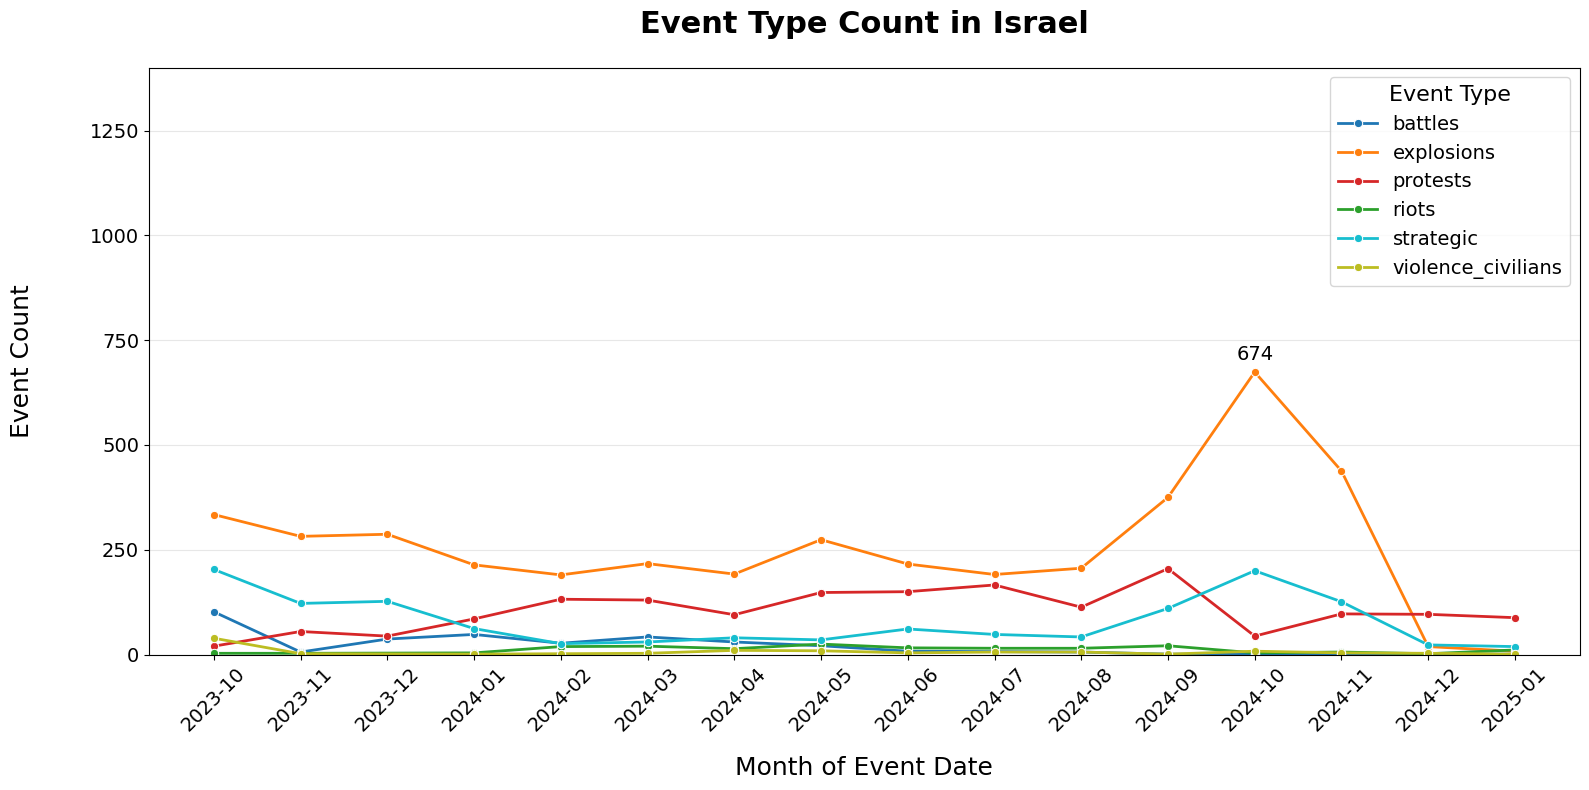

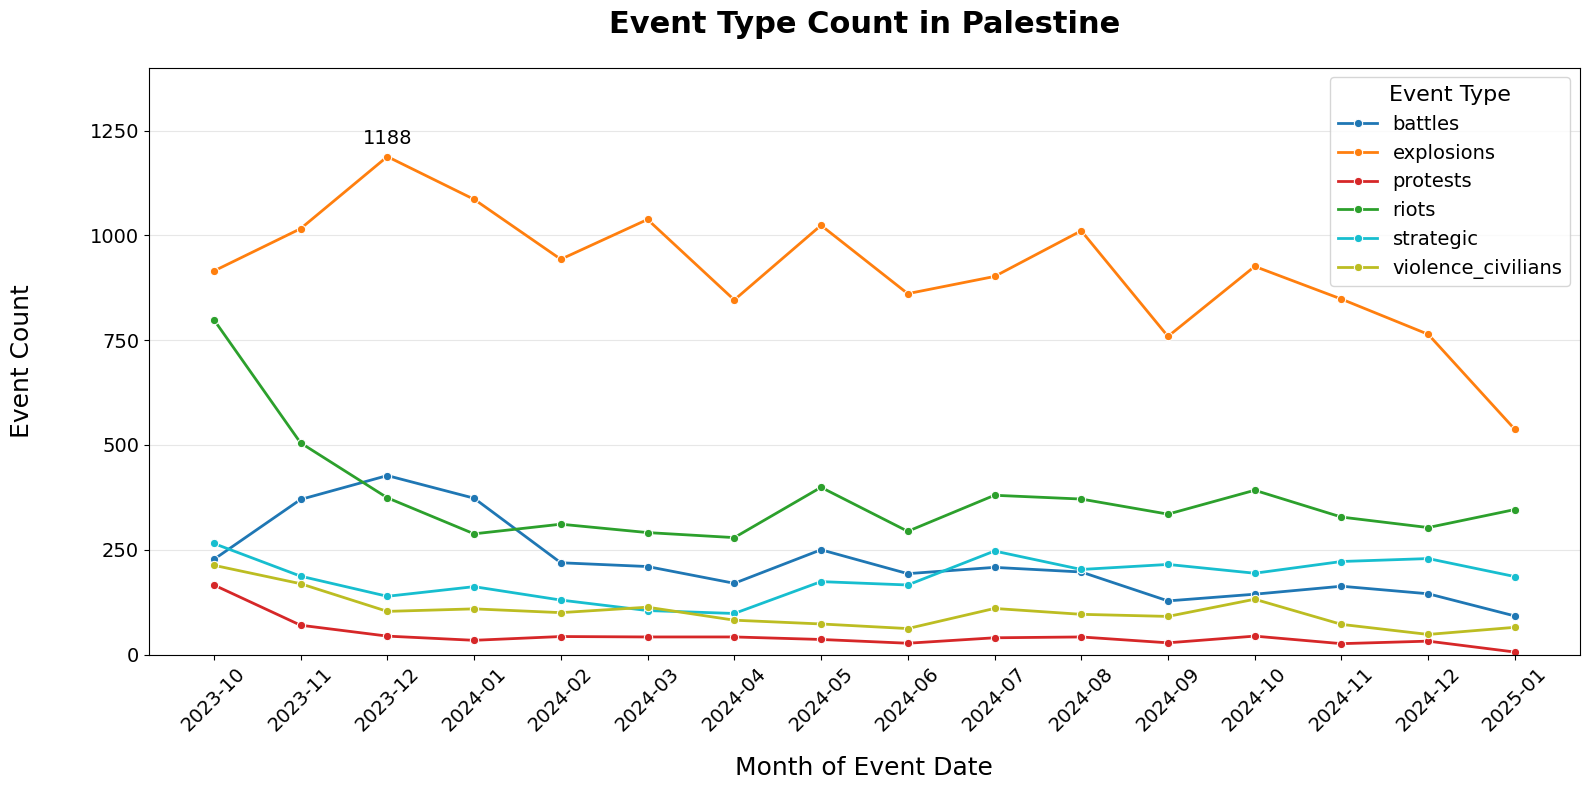

In [15]:
# Visual 1.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract year-month
acled['year_month'] = acled['event_date'].dt.to_period('M').astype(str)

# Filter for Israel and Palestine
acled_israel = acled[acled['country'] == 'Israel']
acled_palestine = acled[acled['country'] == 'Palestine']

# Function to aggregate monthly event counts
def prepare_monthly_data(df):
    return (
        df.groupby(['year_month', 'event_type'])
        .size()
        .reset_index(name='count')
    )

israel_monthly = prepare_monthly_data(acled_israel)
palestine_monthly = prepare_monthly_data(acled_palestine)

# Custom color palette
event_colors = {
    'battles': '#1F77B4',
    'explosions': '#FF7F0E',
    'protests': '#D62728',
    'riots': '#2CA02C',
    'strategic': '#17BECF',
    'violence_civilians': '#BCBD22'
}

# Function to plot monthly trends with Seaborn
def plot_monthly_event_trends(df, country_name, file_name):
    plt.figure(figsize=(16, 8))

    # Draw line chart with seaborn
    ax = sns.lineplot(
        data=df,
        x='year_month',
        y='count',
        hue='event_type',
        palette=event_colors,
        marker='o',
        linewidth=2
    )

    # Fix Y-axis range
    ax.set_ylim(0, 1400)

    # Find and annotate max value for explosions only
    explosions_data = df[df['event_type'] == 'explosions']
    if not explosions_data.empty:
        max_row = explosions_data.loc[explosions_data['count'].idxmax()]
        max_idx = list(df['year_month'].unique()).index(max_row['year_month'])
        ax.text(
            max_idx,
            max_row['count'] + 20,
            str(int(max_row['count'])),
            fontsize=14,
            va='bottom',
            ha='center',
            color='black'
        )

    # Titles and labels
    ax.set_title(f'Event Type Count in {country_name}', fontsize=22, fontweight='bold', pad=25)
    ax.set_xlabel('Month of Event Date', fontsize=18, labelpad=15)
    ax.set_ylabel('Event Count', fontsize=18, labelpad=40)  # Use ax.set_ylabel to enforce labelpad

    # X and Y ticks
    ax.set_xticks(range(len(df['year_month'].unique())))
    ax.set_xticklabels(df['year_month'].unique(), rotation=45, fontsize=14)
    ax.set_yticks(range(0, 1251, 250))
    ax.tick_params(axis='y', labelsize=14)

    # Legend in upper right
    ax.legend(title="Event Type", fontsize=14, title_fontsize=16, loc='upper right')

    # Horizontal grid only
    ax.grid(axis='y', alpha=0.3)
    ax.xaxis.grid(False)

    plt.tight_layout()

    # Save figure
    plt.savefig(file_name, dpi=600, bbox_inches='tight')
    plt.show()

# Export both figures
plot_monthly_event_trends(israel_monthly, "Israel", "Israel_Event_Trend.png")
plot_monthly_event_trends(palestine_monthly, "Palestine", "Palestine_Event_Trend.png")

/tmp/ipython-input-3771789193.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


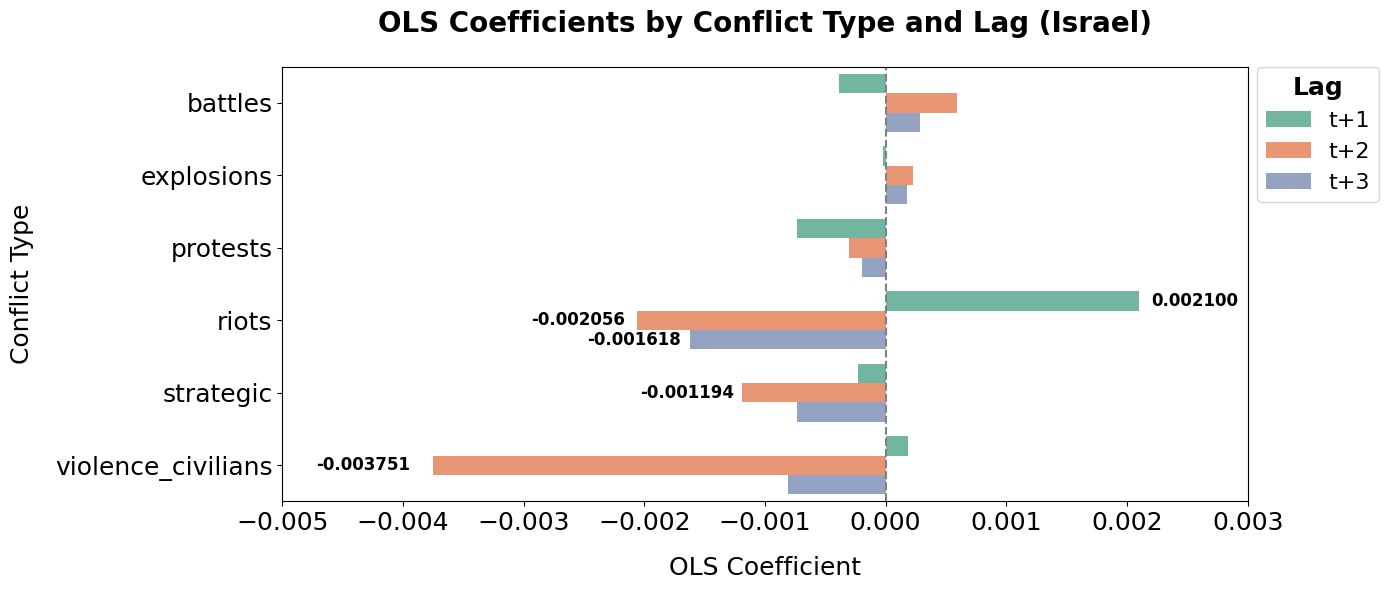

/tmp/ipython-input-3771789193.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


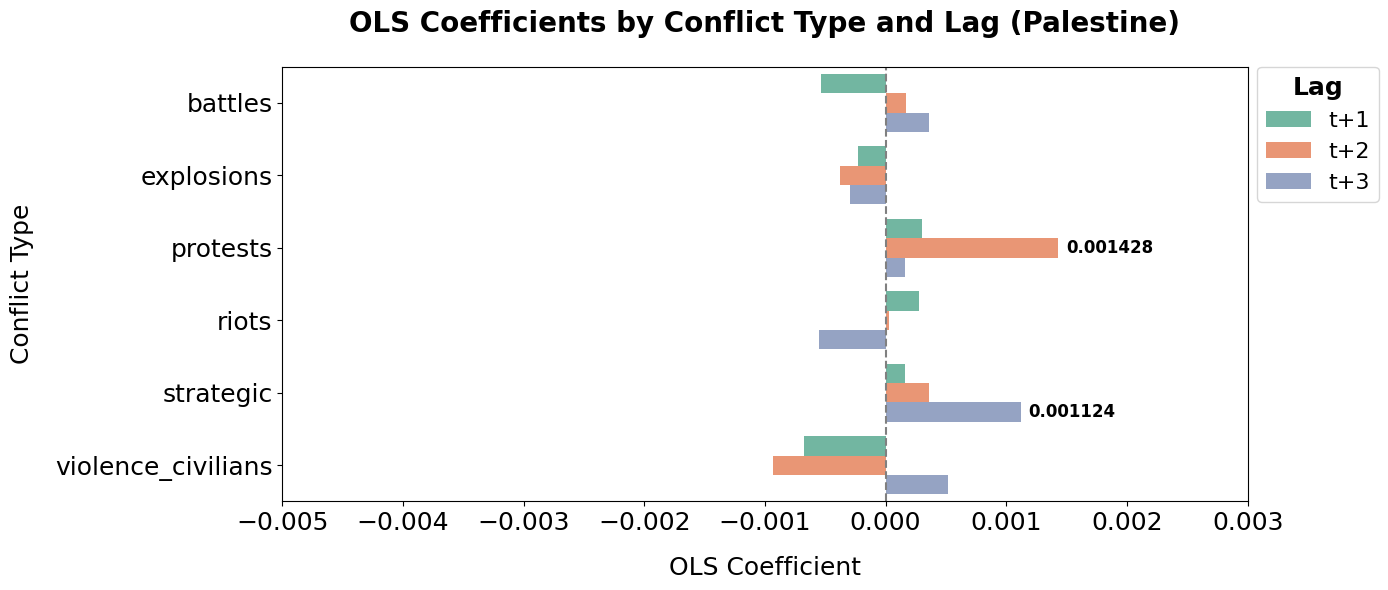

In [16]:
# Visual 2.
# ---- Melt and label data ----
df_israel_melted = coeffs_israel_df.reset_index().melt(
    id_vars='index', var_name='Lag', value_name='Coefficient'
)
df_israel_melted['Region'] = 'Israel'
df_israel_melted.rename(columns={'index': 'Conflict Type'}, inplace=True)

df_palestine_melted = coeffs_palestine_df.reset_index().melt(
    id_vars='index', var_name='Lag', value_name='Coefficient'
)
df_palestine_melted['Region'] = 'Palestine'
df_palestine_melted.rename(columns={'index': 'Conflict Type'}, inplace=True)

# ---- Set a consistent order for conflict types ----
conflict_order = ['battles', 'explosions', 'protests', 'riots', 'strategic', 'violence_civilians']
for df in [df_israel_melted, df_palestine_melted]:
    df['Conflict Type'] = pd.Categorical(df['Conflict Type'], categories=conflict_order, ordered=True)

# ---- Set fixed x-axis limits ----
x_min, x_max = -0.005, 0.003  # Expanded range to prevent labels from being cut off

# ---- Function to plot bar chart with threshold-based coefficient value labels ----
def plot_labeled_bars(df, region_name):
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(
        data=df,
        x='Coefficient',
        y='Conflict Type',
        hue='Lag',
        palette='Set2',
        ci=None
    )
    plt.axvline(0, color='gray', linestyle='--')

    # Title and axis labels
    plt.title(f'OLS Coefficients by Conflict Type and Lag ({region_name})', fontsize=20, fontweight='bold', pad=25)
    plt.xlabel('OLS Coefficient', fontsize=18, labelpad=15)
    plt.ylabel('Conflict Type', fontsize=18, labelpad=15)
    plt.xlim(x_min, x_max)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

    # Legend formatting
    legend = plt.legend(
        title='Lag',
        bbox_to_anchor=(1.01, 1),
        loc='upper left',
        borderaxespad=0,
        fontsize=16,
        title_fontsize=18,
    )
    legend.get_title().set_fontweight('bold')

    # ---- Label only meaningful coefficients (above threshold) ----
    label_threshold = 0.001  # You can adjust this threshold
    for bar, coef in zip(ax.patches, df['Coefficient']):
        if abs(coef) >= label_threshold:
            x = bar.get_width()
            y = bar.get_y() + bar.get_height() / 2
            offset = abs(x) * 0.05  # Dynamic offset to avoid overlapping with the bar
            text_x = max(x_min + 0.00002, min(x + (offset if coef > 0 else -offset), x_max - 0.00002))

            label_text = f'{coef:.6f}'
            plt.text(
                text_x, y, label_text,
                va='center',
                ha='left' if coef > 0 else 'right',
                fontsize=12,
                fontweight='bold'
            )

    plt.tight_layout()
    plt.savefig(f"ols_coefficients_{region_name.lower()}_labeled.png", dpi=600, bbox_inches='tight')
    plt.show()

# ---- Plot for Israel ----
plot_labeled_bars(df_israel_melted, "Israel")

# ---- Plot for Palestine ----
plot_labeled_bars(df_palestine_melted, "Palestine")

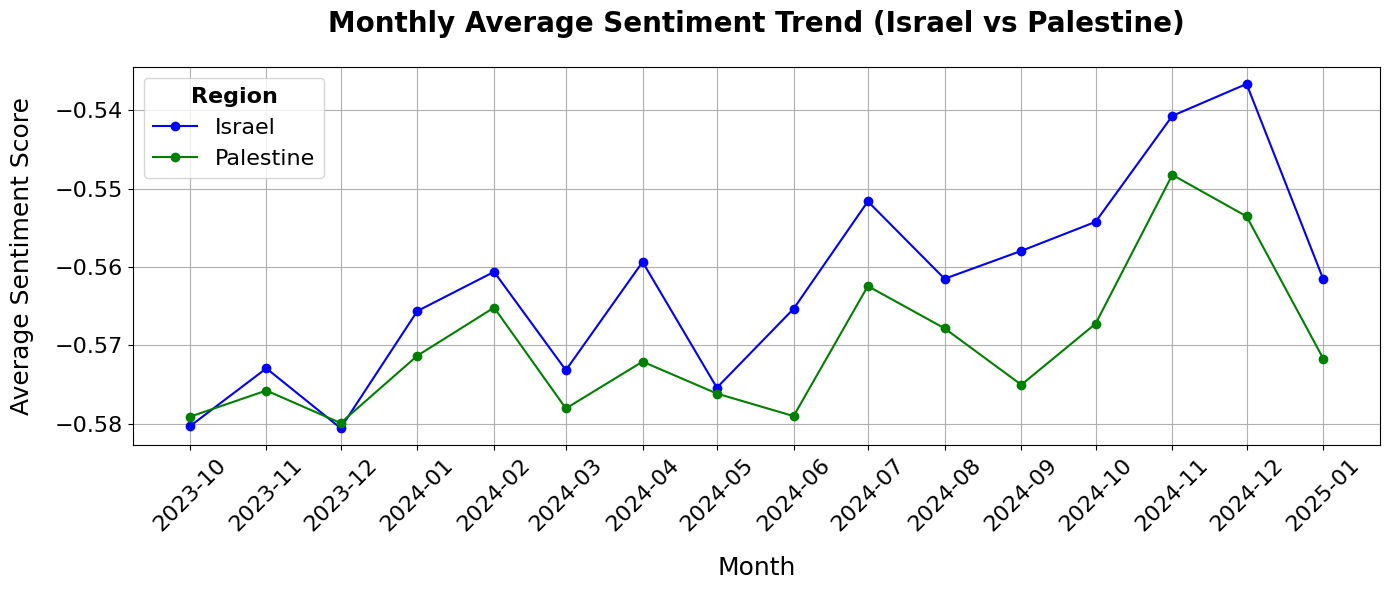

In [17]:
# Visual 3
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_sentiment_monthly_trend_lines(summary_israel, summary_palestine):
    plt.figure(figsize=(14, 6))

    # Plot Israel sentiment trend
    plt.plot(summary_israel['month'], summary_israel['avg_sentiment'],
             marker='o', linestyle='-', color='blue', label='Israel')

    # Plot Palestine sentiment trend
    plt.plot(summary_palestine['month'], summary_palestine['avg_sentiment'],
             marker='o', linestyle='-', color='green', label='Palestine')

    # Title with larger font and spacing
    plt.title(
        "Monthly Average Sentiment Trend (Israel vs Palestine)",
        fontsize=20,
        fontweight='bold',
        pad=25
    )

    # Axis labels with larger font and spacing
    plt.xlabel("Month", fontsize=18, labelpad=15)
    plt.ylabel("Average Sentiment Score", fontsize=18, labelpad=15)

    # X-axis: Monthly ticks with full labels
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # every month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)

    # Grid and legend formatting
    plt.grid(True)
    legend = plt.legend(
        title="Region",
        fontsize=16,
        title_fontsize=16,
        loc='best'
    )
    legend.get_title().set_fontweight('bold')

    # Layout and save
    plt.tight_layout()
    plt.savefig("monthly_sentiment_trend_lines_detailed.png", dpi=600)
    plt.show()

plot_sentiment_monthly_trend_lines(summary_israel, summary_palestine)


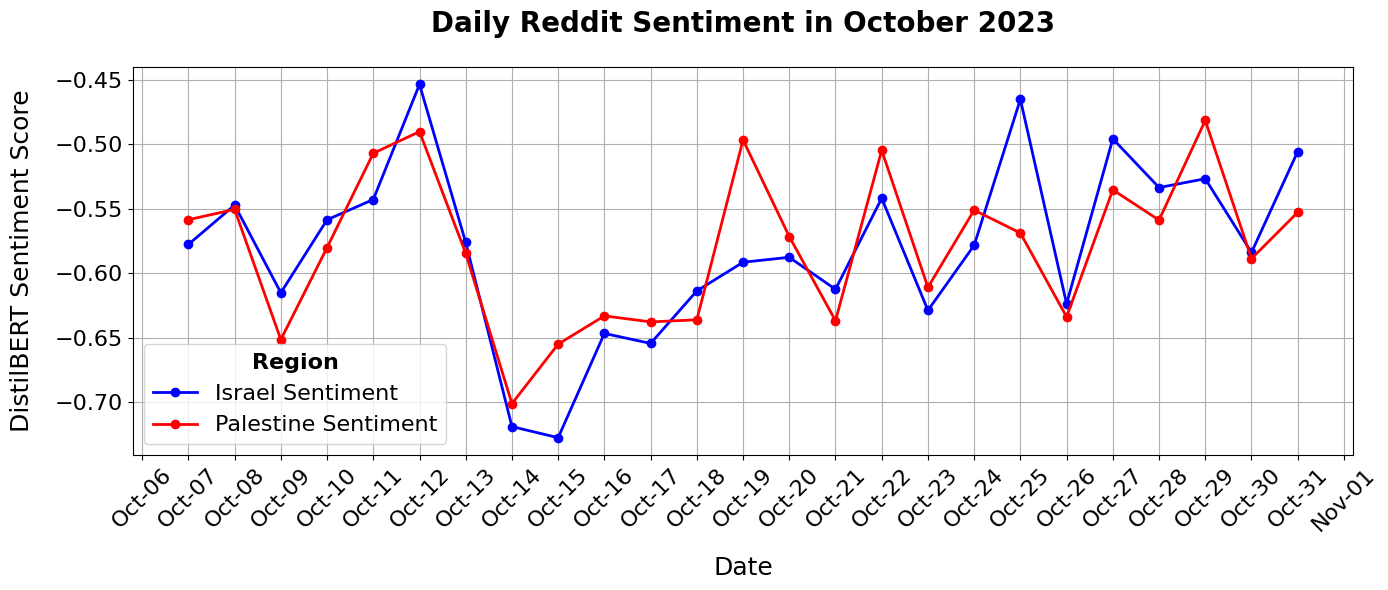

In [18]:
# Visual 4
import matplotlib.dates as mdates

# Ensure 'date' columns are datetime
conflict_israel['date'] = pd.to_datetime(conflict_israel['date'])
conflict_palestine['date'] = pd.to_datetime(conflict_palestine['date'])

# Filter for October 2023
oct_israel = conflict_israel[
    (conflict_israel['date'].dt.year == 2023) & (conflict_israel['date'].dt.month == 10)
]
oct_palestine = conflict_palestine[
    (conflict_palestine['date'].dt.year == 2023) & (conflict_palestine['date'].dt.month == 10)
]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(
    oct_israel['date'],
    oct_israel['sentiment_israel'],
    label='Israel Sentiment',
    color='blue',
    linewidth=2,
    marker='o'
)
plt.plot(
    oct_palestine['date'],
    oct_palestine['sentiment_palestine'],
    label='Palestine Sentiment',
    color='red',
    linewidth=2,
    marker='o'
)

# X-axis settings
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show every day
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)

# Titles and labels with larger font and spacing
plt.title('Daily Reddit Sentiment in October 2023', fontsize=20, fontweight='bold', pad=25)
plt.xlabel('Date', fontsize=18, labelpad=15)
plt.ylabel('DistilBERT Sentiment Score', fontsize=18, labelpad=15)

# Legend formatting
legend = plt.legend(
    title="Region",
    fontsize=16,
    title_fontsize=16,
    loc='best'
)
legend.get_title().set_fontweight('bold')

# Grid and layout
plt.grid(True)
plt.tight_layout()

# Save and show
plt.savefig("sentiment_october_2023.png", dpi=600)
plt.show()

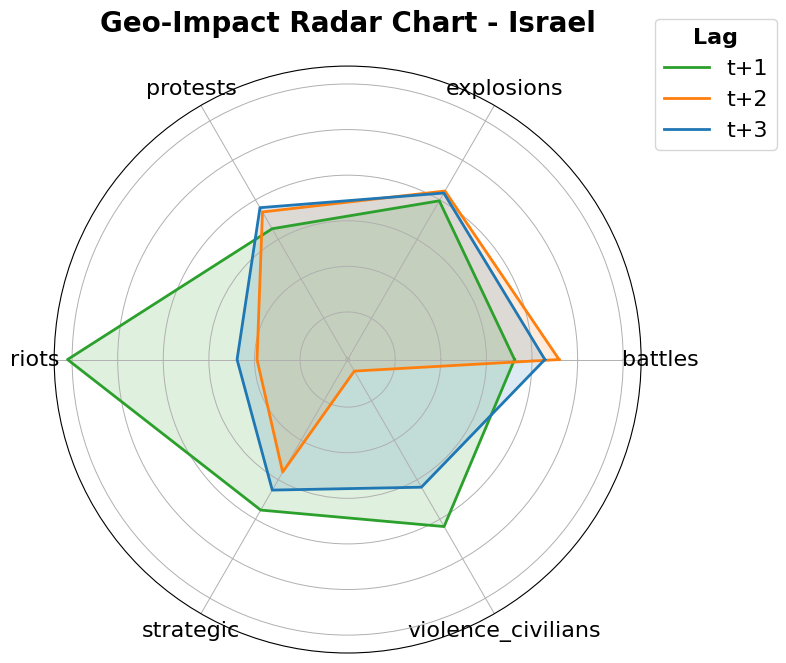

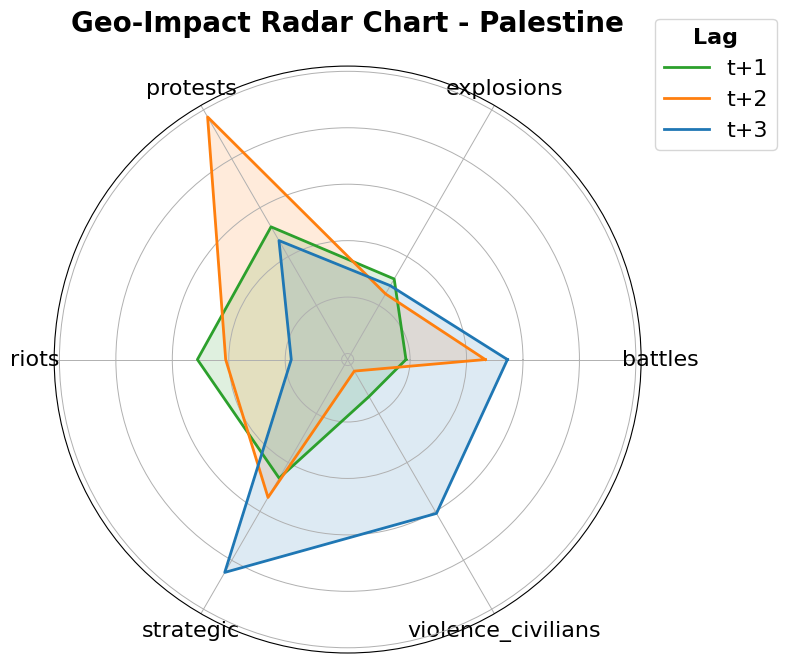

In [19]:
# Visual 5
# Conflict types and lags
conflict_types = ['battles', 'explosions', 'protests', 'riots', 'strategic', 'violence_civilians']
lags = ['t+1', 't+2', 't+3']

# Color scheme per lag
colors = {
    't+1': '#2ca02c',  # green
    't+2': '#ff7f0e',  # orange
    't+3': '#1f77b4',  # blue
}

# Function to plot radar chart
def plot_radar(region_name, coeffs_df):
    angles = np.linspace(0, 2 * np.pi, len(conflict_types), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each lag
    for lag in lags:
        values = coeffs_df[lag].reindex(conflict_types).tolist()
        values += values[:1]
        ax.plot(angles, values, label=lag, color=colors[lag], linewidth=2)
        ax.fill(angles, values, color=colors[lag], alpha=0.15)

    # Title with larger font and spacing
    ax.set_title(f"Geo-Impact Radar Chart - {region_name}", fontsize=20, fontweight='bold', pad=25)

    # Axis labels
    ax.set_thetagrids(np.degrees(angles[:-1]), conflict_types, fontsize=16)
    ax.set_yticklabels([])  # Remove radial tick labels

    # Legend formatting
    legend = ax.legend(
        title="Lag",
        fontsize=16,
        title_fontsize=16,
        loc='upper right',
        bbox_to_anchor=(1.25, 1.1)
    )
    legend.get_title().set_fontweight('bold')

    # Grid styling
    ax.grid(True, linewidth=0.7)

    plt.tight_layout()
    plt.savefig(f"geo_radar_{region_name.lower()}.png", dpi=600, bbox_inches='tight')
    plt.show()

# Draw for Israel
plot_radar("Israel", coeffs_israel_df)

# Draw for Palestine
plot_radar("Palestine", coeffs_palestine_df)